# Predicting El Niño–Southern Oscillation through correlation and time series analysis - Part 3

This notebook is the third part of ENSO prediction and focuses on time seris analysis. Here our SOI time series prediction problem is formulated as a regression problem and the idea is to use prior time steps to predict the next time step(s). Specifically, this analysis consists of three sections:
1. Data cleanup and transformation: transform the raw data into format that supervised machine learning algorithms can take, and split out training and test datasets
2. Model training: train a [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) neural network.
3. Prediction and evaluation: evaluate the models on test dataset and plot the results.

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda update conda
conda install matplotlib
conda install scikit-learn
conda install -c conda-forge keras 
```

## Data cleanup and transformation

Time series data can be phrased as supervised learning if we think of by previous time steps as input variables and the next time step(s) as the output variable. Before we do any transformationm, let's first import all the necessary packages and take a look at what our data looks like.

In [20]:
%matplotlib inline
import os.path
import warnings
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
warnings.filterwarnings('ignore')

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('data/enso_ready.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.head()

,soi,oni,nino3,pna,precip
date,,,,,
1951-01-01,1.5,-0.8,-0.72,-1.18,NaN
1951-02-01,0.9,-0.5,-0.43,-2.11,NaN
1951-03-01,-0.1,-0.2,-0.63,-1.09,NaN
1951-04-01,-0.3,0.2,0.00,0.47,NaN
1951-05-01,-0.7,0.4,-0.12,1.19,NaN


As precipitation data is not available until 1979, let's remove the first few rows, standardize each column by calcuting the z-score, and move soi (input variable) to the last column of the table.

In [25]:
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]
df.head()

,pna,precip,soi,oni,nino3
date,,,,,


Most supervised learning algorithms require all input variables to be on the same row with its corresponding output variable. In SOI prediction, the goal is to use the variables (i.e., oni, nino3, pna, precip, and soi) of the previous time steps (e.g. 12) to predict the SOI of the next time steps (e.g. 3). Formally, the use of prior time steps to predict the next time step is called the sliding window approach (aka window or lag method) in time series analysis/prediction. Therefore, let's define a method that transforms panda time series into format that supervised learning algorithms can take.

In [3]:
"""
This method takes a time series and returns transformed data.
data: time series as pandas dataframe
n_in: number of previous time steps as input (X)
n_out: number of next time steps as output (y)
dropnan: whether or not to drop rows with NaN values
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,-1])
        if i == 0:
            names += ['VAR(t)']
        else:
            names += ['VAR(t+%d)' % i]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Note that after transformation, there are some edges cases where the input or output variable could be NaN. For example, as data before 1979 is not available, there is no way to form a row for SOI of 1979. That's why there is a dropnan option is the method.

In [22]:
enso = df.values.astype('float32')
# specify the sliding window size and number of features
lag = 12
ahead = 3
n_features = 1
reframed = series_to_supervised(enso, lag, ahead)
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),VAR(t),VAR(t+1),VAR(t+2)
12,-0.059963,-0.150376,-1.537109,1.424196,-0.441750,0.056451,-0.271512,-2.725606,0.200227,0.997371,...,0.061769,-0.441750,0.638523,0.587453,-0.678194,-0.032382,-0.750133,0.380605,0.277811,-0.441750
13,0.056451,-0.271512,-2.725606,0.200227,0.997371,0.172865,-0.139364,0.080846,-0.530831,0.072222,...,-0.032382,-0.750133,0.638523,0.411255,-1.007778,-0.076689,0.380605,0.277811,-0.441750,-0.647339
14,0.172865,-0.139364,0.080846,-0.530831,0.072222,0.289280,0.213033,-0.148864,-0.755133,-0.133367,...,-0.076689,0.380605,0.522109,-0.029240,2.028384,-0.804978,0.277811,-0.441750,-0.647339,-0.030572
15,0.289280,0.213033,-0.148864,-0.755133,-0.133367,0.172865,0.036835,1.269344,-0.270530,0.483399,...,-0.804978,0.277811,0.289280,-0.194425,-0.638245,0.269456,-0.441750,-0.647339,-0.030572,-0.030572
16,0.172865,0.036835,1.269344,-0.270530,0.483399,-0.059963,0.279107,-1.636982,-0.068382,0.586194,...,0.269456,-0.441750,0.405694,-0.007215,1.658851,-0.359143,-0.647339,-0.030572,-0.030572,-0.030572


## Model training

Now we have the data, let's define a method that trains a LSTM model. For the purpose of simplicity, we define a two layer neural network with one LSTM layer and one dense layer.

In [5]:
"""
This method takes training data and returns a LSTM model
train: training data
n_lag: number of previous time steps
n_ahead: number of next time steps
nb_epoch: number of epochs
n_neurons: number of n_neurons in the first layer
"""
def fit_lstm(train, n_lag, n_ahead, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, :-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], n_lag, int(X.shape[1]/n_lag))

    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(n_ahead))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
        model.reset_states()
    return model

Let's split our transformed data into training and test sets and feed the model training method. The first 80 precent will be used for training purpose and the last 20 percent will be using as test set. Note that in time sereis analysis, we don't do random shuffle because it's important to preserve time dependency/order.

In [6]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# fit model
file_path = 'data/my_model.h5'
if not os.path.exists(file_path):
    model = fit_lstm(train, lag, ahead, 1, 30, 30)
    model.save(file_path)
else:
    model = load_model(file_path)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 30)                   4320      
_________________________________________________________________
dense_4 (Dense)              (1, 3)                    93        
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________


## Precition and evaluation

Now let's apply the model to the test set and evaluate the accuracy for each of those three next time steps.

In [8]:
# predict the SOI values for next three time steps given a single input sample 
def forecast_lstm(model, X, n_batch, n_lag):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, n_lag, int(len(X)/n_lag))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# make prediciton for a list of input samples
def make_forecasts(model, n_batch, train, test, n_lag, n_ahead):
    forecasts = list()
    for i in range(len(test)):
        X = test[i, :-n_ahead]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch, n_lag)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [9]:
forecasts = make_forecasts(model, 1, train, test, lag, ahead)
# pring out the output for the first input sample
forecasts[0]

[-1.5042609, -1.4436339, -1.52989]

As mentioned in the very beginning, time series prediction is treated as a regression problem in our case, so let's compute mean square error (MSE) for each next time step.

In [19]:
def evaluate_forecasts(y, forecasts, n_lag, n_seq):
    print('Evaluation results (RMSE) for each next tim step:')
    for i in range(n_seq):
        actual = [row[i] for row in y]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d time step: %f' % ((i+1), rmse))
        
# evaluate forecasts
actual = [row[-ahead:] for row in test]
evaluate_forecasts(actual, forecasts, lag, ahead)

Evaluation results (RMSE) for each next tim step:
t+1 time step: 0.795490
t+2 time step: 0.843505
t+3 time step: 0.907717


To to a better understanding of the prediction result, let's plot it out and compare with with the original data.

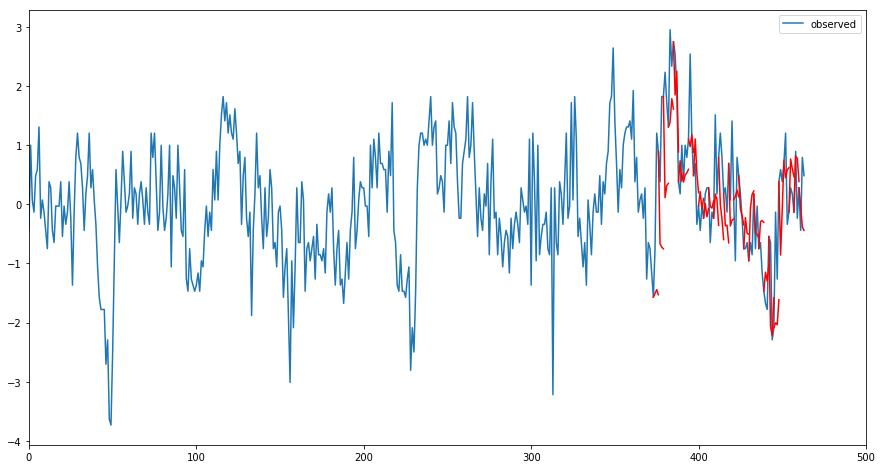

In [14]:
# plot the forecasts in the context of the original dataset, multiple segments
def plot_forecasts(series, forecasts, n_test, xlim, ylim, n_ahead, linestyle = None):
    pyplot.figure(figsize=(15,8))
    if linestyle==None:
        pyplot.plot(series, label='observed')
    else:
        pyplot.plot(series, linestyle, label='observed')
    pyplot.xlim(xlim, ylim)
    pyplot.legend(loc='upper right')
    # plot the forecasts in red
    for i in range(len(forecasts)):
        # this ensures not all segements are plotted, it is plotted every n_ahead
        if i%n_ahead ==0:
               off_s = len(series) - n_test + 2 + i - 1
               off_e = off_s + len(forecasts[i]) + 1
               xaxis = [x for x in range(off_s, off_e)]
               yaxis = [series[off_s]] + forecasts[i] 
               pyplot.plot(xaxis, yaxis, 'r')
    pyplot.show()
    
plot_forecasts(df['soi'].values, forecasts, test.shape[0] + ahead - 1, 0, 500, ahead)

Here the blue line is the ogriginal time series, the red line is the prediction results. As we can see, it is doing a reasonable job. With more sophisicated modeling tuning and architecture desgin, better results could be achieved.